# Workshop 1: Analyzing connectomics datasets: V1dd

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   
<font size=4> The function of the nervous system arises out of a combination of the properties of individual neurons and the properties of how they are connected into a larger network. The central goal of <b>connectomics</b> is to produce complete maps of the connectivity of the nervous system with synaptic resolution and analyze them to better understand the organization, development, and function of the nervous system. </font>

<font size=4><b>Electron Microscopy (EM) data enables morphological reconstruction of neurons and resolution of their synaptic connectivity </b>. The V1DD dataset is one of the largest volume EM datasets currently available, and spans all layers of mouse visual cortex. We will be using this dataset to query the connectivity between neurons in the visual cortex. </font>

<b> The V1DD dataset is newly public. </b> Previous years of this course have used the [MICrONS Dataset](https://www.microns-explorer.org/), which is also a cubic millimeter volume of mouse visual cortex. Both datasets are available for the use of this course, but we will cover V1DD in Week 1.


<h3> Workshop aims</h3>
<ul>
    <li> Understand what are the major classes of cell types in cortex</li>
    <li> Understand the basics of how synaptic connectivity is measured in EM connectomics</li>
    <li> Look at the relationship between the structure of networks and cell type connectivity</li>
    <li> Look at the relationship between functional tuning properties of neurons and how they are connected in the network </li>

</ul>
    

<h4> Workshop 1 will cover: </h4>
<ol> 
    <li>Reconstructions of individual neurons</li>
    <li>Connectivity of individual neurons</li>
    <li>Connectivity between cell types</li>
    <li>Connectivity by connection type (spine, soma, shaft)</li>
</ol>

<h4> Workshop 2 will cover: </h4>
<ol> 
    <li>Connection probability as a function of distance</li>
    <li>Reciprocal connections </li>
    <li>Relationship between structure and function </li>
    <li>Designing null models to test for meaningful connectivity </li>
</ol>

<em> Note on data access: </em> To make this workshop easier, we already queried the most of the data needed for this exercise from the database. We have made it available as versioned files that can be read with pandas. The entire dataset is hosted using the <a href=https://caveconnectome.github.io/sections/cave_overview.html> Connectome Annotation Versioning Engine (CAVE) </a>. A separate notebook shows how to use CAVE to generate the files used in this notebook. (!BD Link final data products notebook)
    
    
</div>

In [1]:
mat_version = 1169

import os
import sys
from os.path import join as pjoin

HOME = os.path.expanduser("~")
# data_dir = f"{HOME}/SWDB_2025_Connectomics/data/{mat_version}"

# # NOTE: adjust for your system
# data_dir = f"{HOME}/code/swdb/SWDB_2025_Connectomics/data/{mat_version}"
# utils_dir = f"{HOME}/code/swdb/SWDB_2025_Connectomics/code/utils"

# # NOTE: adjust for your system
data_dir = pjoin('..','..','data', f"v1dd_{mat_version}")
utils_dir = pjoin("..","utils")

sys.path.append(utils_dir)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Import packages </h2>
   
<b> The CAVEclient</b> is a python library that facilitates communication with a CAVE system. For convenience, we also use the package <b>skeleton_plot</b> which handles rendering the precomputed skeletons. 
   
</div>

In [2]:
# Import packages
from caveclient import CAVEclient
import skeleton_plot as skelplot

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.sparse import csr_array
from typing import Union, Optional

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   
<b> CAVE account setup (MICrONS)</b>

(! Note: this remains pinned to MICrONS for the purpose of the 8/5/2025 walkthrough because V1DD is not yet public)

<p>In order to manage server traffic, every user needs to create a CAVE account and download a user token to access CAVE's services programmatically. The CAVE infrastructure can be read about in <a href='https://doi.org/10.1038/s41592-024-02426-z'>more detail in the MICrONS Nature Package</a>. The MICrONS data is publicly available which means that no extra permissions need to be given to a new user account to access the data. Bulk downloads of some static data are also available without an account on <a href='https://microns-explorer.org/'> MICrONs Explorer</a>.

<b> A Google account (or Google-enabled account) is required to create a CAVE account.

<p> Go to: <a href=https://global.daf-apis.com/auth/api/v1/user/token> https://global.daf-apis.com/auth/api/v1/user/token </a>to view a list of your existing tokens
<p> If you have never made a token before: 
<ol>
  <li>go here: <a href=https://global.daf-apis.com/sticky_auth/api/v1/tos/2/accept>https://global.daf-apis.com/sticky_auth/api/v1/tos/2/accept</a> to accept terms of service</li>
  <li>then go here <a href=https://global.daf-apis.com/sticky_auth/api/v1/tos/2/accept> https://global.daf-apis.com/auth/api/v1/create_token</a> to create a new token.</li>
</ol>

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   
<b> CAVE account setup (V1DD)</b>

<p>In order to manage server traffic, every user needs to create a CAVE account and download a user token to access CAVE's services programmatically. The CAVE infrastructure can be read about in <a href='https://doi.org/10.1038/s41592-024-02426-z'>more detail in the MICrONS Nature Package</a>. 

<b> A Google account (or Google-enabled account) is required to create a CAVE account.

<p> Go to: <a href=https://global.em.brain.allentech.org/auth/api/v1/user/token> https://global.daf-apis.com/auth/api/v1/user/token </a>to view a list of your existing tokens
<p> If you have never made a token before: 
<ol>
  <li>then go here <a href=https://global.em.brain.allentech.org/auth/api/v1/create_token> https://global.daf-apis.com/auth/api/v1/create_token</a> to create a new token.</li>
</ol>

</div>

In [3]:
# my_token = "PASTE_TOKEN_HERE"
# client = CAVEclient(datastack_name='v1dd', server_address="https://global.em.brain.allentech.org", auth_token=my_token)

client = CAVEclient('v1dd') 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p><b>Tip for CodeOcean users</b>: you can add the the CAVEclient token to your capsule's secrets, so you do not have to enter it every time. If you chose to use EM data for your project in Week 2 we can show you how. 

<p>If you are running this on your local system you can save the token with the following:</p>

```python
client.auth.save_token(token=my_token, overwrite=True)

```

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

    
## Interactive session in neuroglancer

Instructions in the DataBook (!BD add final link)

<font size=4> <a href=https://spelunker.cave-explorer.org/#!middleauth+https://global.daf-apis.com/nglstate/api/v1/6129142897573888> V1DD Neuroglancer Explorer </a></font>


<font size=4> <a href=https://spelunker.cave-explorer.org/#!middleauth+https://global.daf-apis.com/nglstate/api/v1/5198011033452544> MICrONS Neuroglancer Explorer </a></font>

You will be prompted for a google login. Use the same account you used to authenticate your CAVE token
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

    
## Proofreading and data quality

Understanding this variablity in data quality is critical when interpretting electron microscopy reconstructions.

Automated segmentation of neuronal processes in dense EM imaging is challenging at the size of entire neurons, which can have millimeters of axons and dendrites. The automated segmentation algorithms used in the EM data for this project are not perfect, and so proofreading is necessary to obtain accurate reconstructions of a cell and confidence in the connectivity

In general, the **dendrites** of single-soma detected neurons are considered trustworthy, even without proofreading. However the **axons** require manual effort to both clean and extend. 

For details on the proofreading status see: 

* DataProducts.ipynb(!BD add final link to notebook) for how the data we use today was generated
* Proofreading page in the SWDB databook(!BD add final link). 

<b> For this workshop, we treat all cells with at least `axon_partially_extended` as equally trustworth.</b> This may not be a safe assumption for all analysis, and we are happy to provide more guidance depending on the research question.

<font size=3>Load the prepared variables: <code>dendrite_proof_root_ids</code> and <code>axon_proof_root_ids</code> </font>
    
</div>

In [4]:
# Loads cells with axon and dendrite proofreading
dendrite_proof_root_ids = np.load(pjoin(data_dir, f'proofread_dendrite_list_{mat_version}.npy'))
axon_proof_root_ids = np.load(pjoin(data_dir, f'proofread_axon_list_{mat_version}.npy'))

print(f'There are {len(dendrite_proof_root_ids)} cells with acceptable dendrites, and {len(axon_proof_root_ids)} cells with axon proofreading')
print(f'The number of cells with usable axons and dendrites is: {len(np.isin(axon_proof_root_ids, dendrite_proof_root_ids))}')

There are 63937 cells with acceptable dendrites, and 1207 cells with axon proofreading
The number of cells with usable axons and dendrites is: 1207


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
## Neuron morphology: representing neurons as skeletons

Often in thinking about neurons, you want to measure things along a linear dimension of a neuron.

However, the segmentation and meshes are a complex 3D shape that makes this non-trivial. There are methods for reducing the shape of a segmented neuron down to a linear tree like structure usually referred to as a **skeleton**. We have precalculated skeletons for a large number of cells in the dataset, and make the skeleton generation available on our server, on demand.

*Note*: The meshes you see in Neuroglancer are available to download through the python client `cloud-volume`, and can be loaded for analysis and visualization in other tools. This is useful for some types of analysis (and for making beautiful renders of neurons), but we will not cover that in this course.

<font size=4> First, define a convenience function for plotting skeletons. </font>
    
</div>

In [5]:
# Color map for the different comparments. You may adjust these to your asthetic.
skel_color_map = {3: "firebrick", 4: "salmon", 2: "steelblue", 1: "olive"}

def plot_skeleton(sk_d: dict, plot_soma=True, ax=None):
    """Plots a skeleton.

    Args:
        sk: skeleton dict as returned from CAVEclient

    Returns:
        ax: plot axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 10), dpi=150)

    skelplot.plot_tools.plot_verts(
        np.array(sk_d["vertices"]),
        np.array(sk_d["edges"]),
        radius=np.array(sk_d["radius"]) / 1000 * 1,
        ax=ax,
        skel_colors=sk_d["compartment"],
        title="",
        skel_alpha=1.0,
        line_width=5,
        x="x", # You can alter the projection direction by changing this to `y` or `z`
        y="y", # You can alter the projection direction by changing this to `x` or `z`
        plot_soma=plot_soma,
        soma_node=sk_d["root"],
        color="darkslategray",
        soma_size=120,
        invert_y=True,
        skel_color_map=skel_color_map,
        x_min_max=None,
        y_min_max=None,
        capstyle="round",
        joinstyle="round",
    )

    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.axis("off")

    return ax

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<font size=4> Select one of the axon-proofread cells to plot as a skeleton. </font>

</div>

In [6]:
# select from the cells which are fully extended
root_id = axon_proof_root_ids[1] # iterate this number to choose a different cell

# Query the skeleton from CAVEclient
sk_d = client.skeleton.get_skeleton(root_id, output_format="dict")

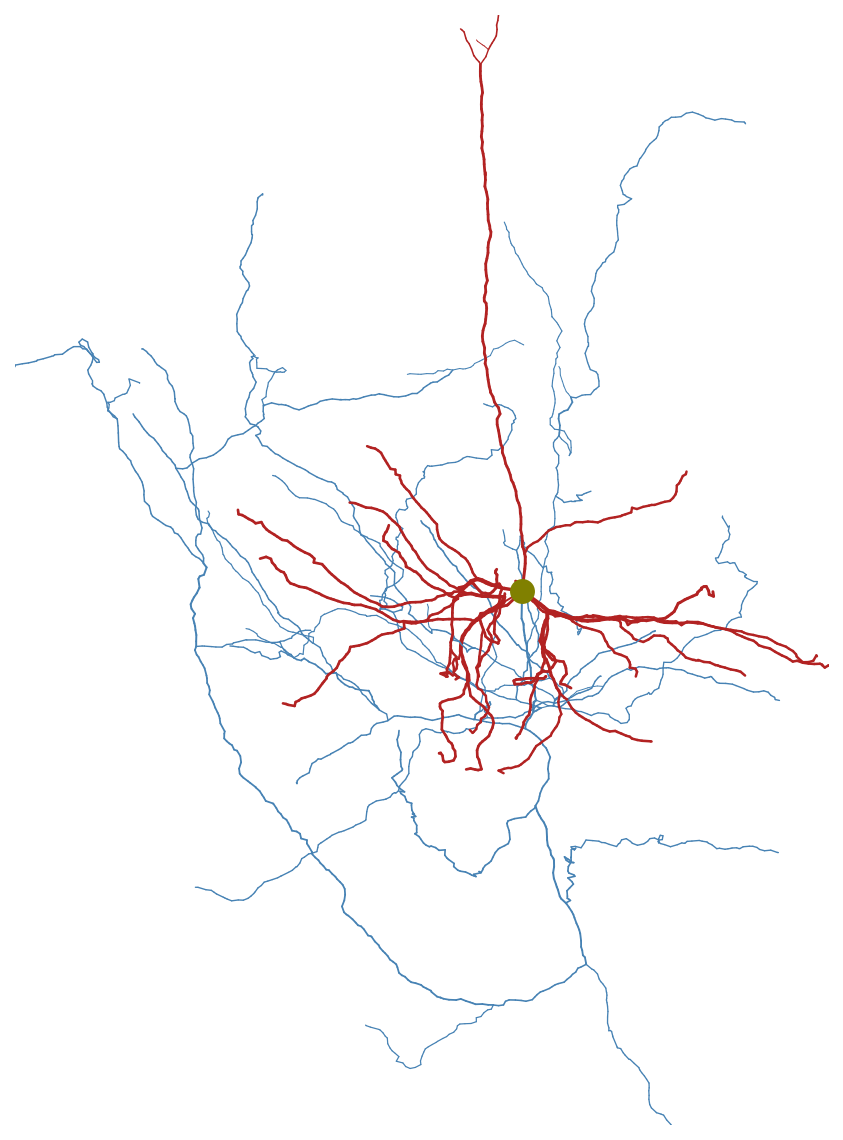

In [7]:
# Plot skeleton in 2D
ax = plot_skeleton(sk_d)
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h4> Morphological compartment names </h4>

<p> The compartment types defined at each vertex adhere to standardized conventions for neuronal morphologies saved as swc files (for more information, see here: www.neuromorpho.org). </p>
    
These conventions are as follows:
<ul> 
    <li> 0 - undefined </li>
    <li> 1 - soma (default color 'olive') </li>
    <li> 2 - axon (default color 'steelblue') </li>
    <li> 3 - (basal) dendrite (default color 'firebrick' red) </li>
    <li> 4 - apical dendrite </li>
    <li> 5+ - custom </li>
</ul>

In most of these neurons, distinctions were not made between basal or apical dendrites - therefore dendrites should almost exclusively map to compartment type "3".

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1:</b> Plot several different skeletons by changing the <code> root_id </code> entry. You can either iterate through the <code>axon_proof_root_ids</code> list, or paste the segment id from neuroglancer.

<b>Discussion:</b> What information do you lose going from 3D neuron meshes (neuroglancer) to 2D skeleton projections? What becomes more clear?
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

    
## Synapse information

While synapses are stored as any other CAVE table in the database, in this case `synapses_v1dd`, this table is much larger than any other table at almost <b>640 million rows</b>, and it works best when queried in a directed way.

For today's workshop we have collected all of the input and output synapses for the proofread cells When accessing CAVE, the `synapse_query()` function allows you to query the synapse table in a more convenient way than most other tables. In particular, the `pre_ids` and `post_ids` let you specify which root id (or collection of root ids) you want to query, with pre_ids indicating the collection of presynaptic neurons and post_ids the collection of postsynaptic neurons.

Note that synapse queries always return the list of every synapse between the neurons in the query, even if there are multiple synapses between the same pair of neurons.

A common pattern to generate a list of connections between unique pairs of neurons is to group by the root ids of the presynaptic and postsynaptic neurons and then count the number of synapses between them. 

<font size=4> Load the table of connections between proofread cells (about <b> 8 million </b> entries) </font>
    
</div>

In [8]:
syn_df = pd.read_feather(
    f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather"
)

print(syn_df.shape)

syn_df.head(3)

(8190075, 13)


,id,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id
0,354386968,758200.5,802316.1,304380.0,757861.0,802558.6,304650.0,757967.7,802597.4,304380.0,240,864691132536286810,864691132734919083
1,220616943,574501.9,337249.6,258570.0,574152.7,337016.8,258570.0,574337.0,336900.4,258570.0,420,864691132558380553,864691132828255906
2,119675985,444260.0,602544.6,3285.0,443988.4,602311.8,3555.0,444182.4,602370.0,3780.0,3637,864691132572564252,864691132654028028


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

    

<ul>This table has a number of columns, we will highlight the most important
    <li><b> id:</b> a unique ID for each synapse </li>
    <li><b> pre_pt_root_id:</b> the segmentation ID of the pre-synaptic compartment</li>
    <li><b> post_pt_root_id:</b> the segmentation ID of the post-synaptic compartment</li>
    <li><b> size:</b> a measure of the synapse size (the number of 4,4,40 nm voxels in the synapse mask) best available metric of synaptic weight</li>
    <li><b> ctr_pt_position_{x,y,z}:</b> the location of the synapse in the cleft, stored here in nanometers</li>
    <li><b> pre_pt_position_{x,y,z}:</b> a point just in the presynaptic compartment of synapse (used to lookup pre_root_id), stored here in nanometers</li>
    <li><b> post_pt_position_{x,y,z}:</b> a point just in the postsynaptic compartment of synapse (used to lookup post_pt_root_id), stored here in nanomaters</li>
</ul>

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

    
## Combining neuron morphology & synapses

<p> Next we will visualize the synapses on the skeleton of your cell of interest. </p>

<p> Here we define a convenience function for robustly filtering the synapse table by pre- or post-synaptic partners. You will use this through the rest of the exercises. </p> 
    
</div>

In [9]:
def filter_synapse_table(
    synapse_table: pd.DataFrame, pre_root_ids=None, post_root_ids=None
):
    """Filter synapse table by pre and post root ids.

    Args:
        synapse_table: synapse table with pre_pt_root_ids and post_pt_root_ids as pd.DataFrame
        pre_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the presynaptic side
        post_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the postsynaptic side

    Returns:
        synapse_table: filtered synapse table
    """

    if pre_root_ids is not None:
        assert isinstance(pre_root_ids, (np.ndarray, list, pd.core.series.Series)), (
            f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        )
        pre_mask = np.isin(synapse_table["pre_pt_root_id"], pre_root_ids)
    else:
        pre_mask = np.ones(len(synapse_table), dtype=bool)

    if post_root_ids is not None:
        assert isinstance(post_root_ids, (np.ndarray, list, pd.core.series.Series)), (
            f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        )
        post_mask = np.isin(synapse_table["post_pt_root_id"], post_root_ids)
    else:
        post_mask = np.ones(len(synapse_table), dtype=bool)

    return synapse_table[pre_mask & post_mask]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

    
<h3> Collect the output synapses for your cell of interest. </h3>

The nomenclature here is that you want synapses where your cell is the **presynaptic** partner

</div>

In [10]:
# select from the cells which are fully extended
root_id = axon_proof_root_ids[1] # iterate this number to choose a different cell

# Query the skeleton from CAVEclient
sk_d = client.skeleton.get_skeleton(root_id, output_format="dict")

pre_syns = filter_synapse_table(syn_df, pre_root_ids=[root_id])

pre_syns.head(5)

,id,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id
133,402558233,839602.9,564646.7,228735.0,839515.6,565160.8,229410.0,839699.9,565034.7,229095.0,3881,864691132534315610,864691132726874269
207,292446107,675478.9,569525.8,361440.0,675333.4,569700.4,361125.0,675469.2,569603.4,361305.0,1082,864691132534315610,864691132620269499
380,438169048,865899.6,475571.6,202005.0,865725.0,476095.4,202230.0,865695.9,475872.3,202005.0,5146,864691132534315610,864691132569299996
398,409065816,843327.7,769995.7,336240.0,843395.6,770277.0,336420.0,843405.3,770315.8,336285.0,1694,864691132534315610,864691133066825032
469,397169708,811715.4,751885.8,267750.0,811715.4,751730.6,267525.0,811763.9,751720.9,267750.0,1664,864691132534315610,864691132959793255


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

    
Add the synapse positions to yours skeleton. We use:

<ul>
    <li><b> ctr_pt_position_{x,y,z}:</b> the location of the synapse in the cleft, stored here in nanometers</li>
</ul>

</div>

<Axes: xlabel='ctr_pt_position_x', ylabel='ctr_pt_position_y'>

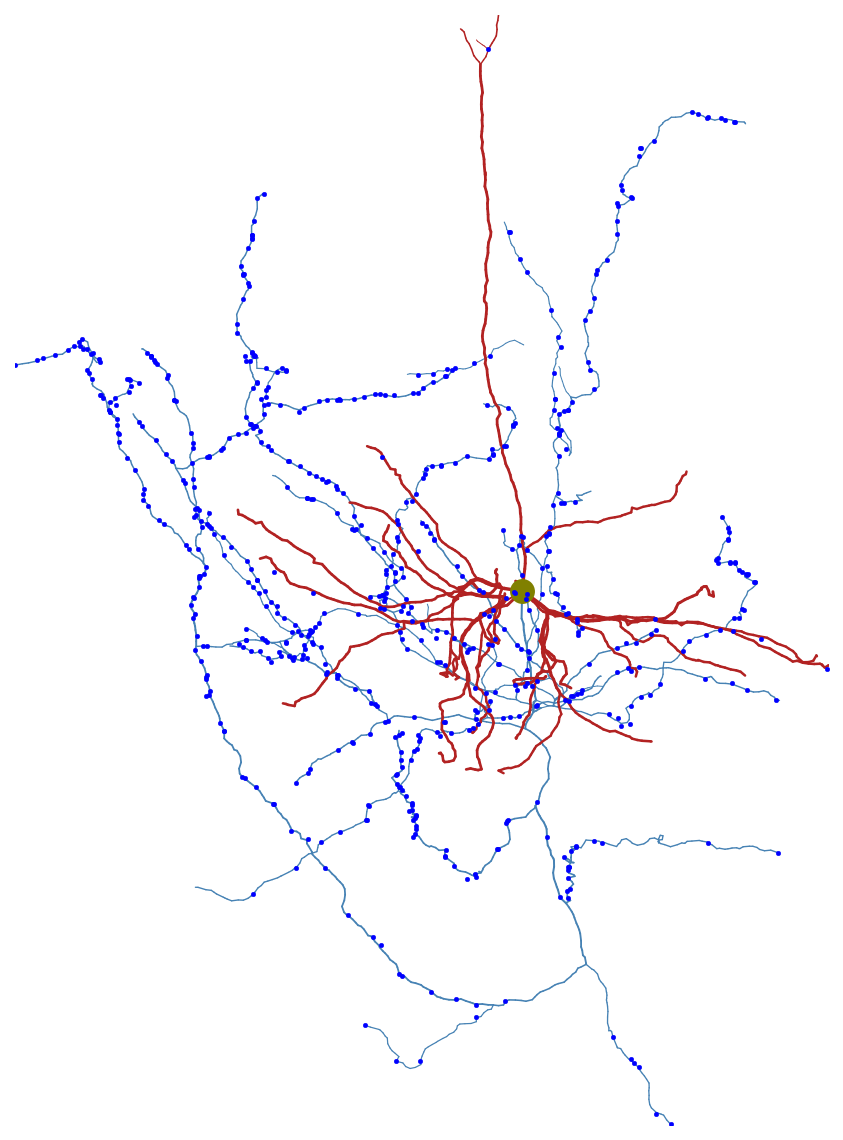

In [11]:
# Plot your skeleton and overlay synapses
ax = plot_skeleton(sk_d)

sns.scatterplot(
    data=pre_syns,
    x="ctr_pt_position_x",
    y="ctr_pt_position_y",
    s=5,
    color="b",
    ax=ax,
    edgecolor=None,
    zorder=100,
)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2:</b> Now use the filter function above to create a dataframe of all postsynaptic synapses and create a version of the plot above that includes these postsynaptic synapses. 
    
</div>

In [12]:
# Select the synapses where your root_id is postsynaptic ('downstream'); the inputs to your cell
post_syns = filter_synapse_table(syn_df, post_root_ids=[root_id])

<Axes: xlabel='ctr_pt_position_x', ylabel='ctr_pt_position_y'>

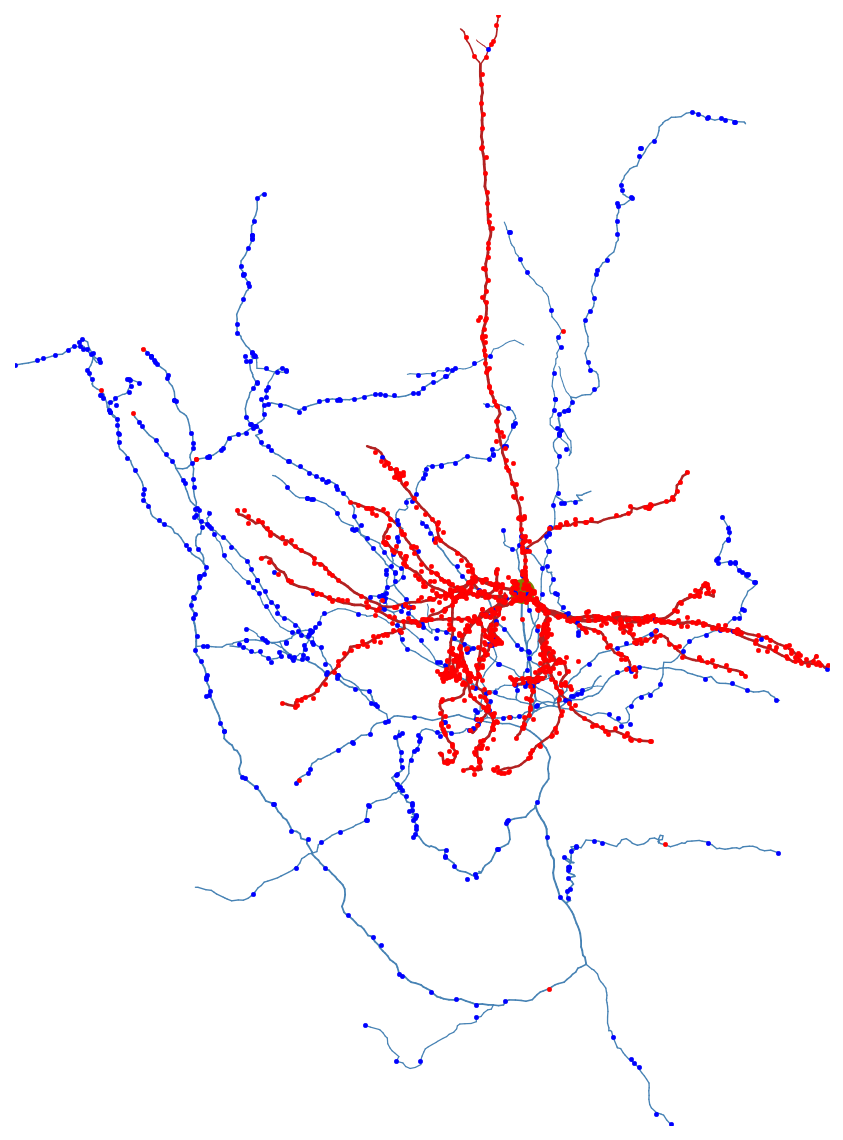

In [13]:
# Plot skeleton with input and output synapses
ax = plot_skeleton(sk_d)

sns.scatterplot(
    data=pre_syns,
    x="ctr_pt_position_x",
    y="ctr_pt_position_y",
    s=5,
    color="b",
    ax=ax,
    edgecolor=None,
    zorder=100,
)

sns.scatterplot(
    data=post_syns,
    x="ctr_pt_position_x",
    y="ctr_pt_position_y",
    s=5,
    color="r",
    ax=ax,
    edgecolor=None,
    zorder=100,
)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3:</b> Repeat the plotting code up to this point with a different neuron, changing the <code> root_id </code> variable above. 

<p> Try several, until you see something you haven't seen before. </p>

<b> Discussion </b>: what do you notice about the distribution of synapses relative to the soma of different cells? Above/below? Narrow or broad? What about the density of synapses on parts of the dendrites or axons?

How would you quantify these features?
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Synapse matrix

The synapses between neurons create a network of synaptic connections. One way of visualizing this connectivity is in matrix form. 

For now, we will limit ourselves to the synapses between the proofread neurons.

</d>

In [14]:
# get the ids of all proofread cells with both axon and dendrite proofreading
proof_root_ids = axon_proof_root_ids[
    np.isin(axon_proof_root_ids, dendrite_proof_root_ids)
]

# filter for synapses between the proofread cells (pre and post)
proof_proof_syn_table = filter_synapse_table(
    syn_df, pre_root_ids=proof_root_ids, post_root_ids=proof_root_ids
)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Next we will make an **adjacency plot** from the tabular synapse data, turning it into a matrix the describes the connection strength between all possible partners. For convenience we have provided a function `make_adjacency` to perform the ordered groupbys and aggregations. 

(!BD add function arguments descriptions)

</d>

In [15]:
def check_index(
    index: Union[pd.Index, pd.DataFrame, pd.Series, np.ndarray, list],
) -> pd.Index:
    if isinstance(index, (pd.DataFrame, pd.Series)):
        index = index.index
    elif isinstance(index, (np.ndarray, list)):
        index = pd.Index(index)
    else:
        raise TypeError(
            f"Index has to be of type pd.DataFrame, pd.Series, np.ndarray or list; got {type(index)}"
        )
    return index


def make_adjacency(
    synapses,
    source_cell_index: Union[pd.Index, pd.DataFrame, pd.Series, np.ndarray, list],
    target_cell_index: Optional[
        Union[pd.Index, pd.DataFrame, pd.Series, np.ndarray, list]
    ] = None,
    aggfunc="binary",
) -> csr_array:
    source_cell_index = check_index(source_cell_index)
    if target_cell_index is None:
        target_cell_index = source_cell_index
    else:
        target_cell_index = check_index(target_cell_index)
    synapses = synapses.query(
        "pre_pt_root_id in @source_cell_index and post_pt_root_id in @target_cell_index"
    )
    groupby = synapses.groupby(["pre_pt_root_id", "post_pt_root_id"])
    if aggfunc == "count":
        edges = groupby.size().rename("weight").reset_index()
    elif aggfunc == "binary":
        edges = groupby.size().transform(lambda x: x > 0).rename("weight").reset_index()
    else:
        edges = groupby["size"].agg(aggfunc).rename("weight").reset_index()
    # make sure that the adjacency matrix is sorted the same as the input cell index
    edges["source_index"] = source_cell_index.get_indexer(edges["pre_pt_root_id"])
    edges["target_index"] = target_cell_index.get_indexer(edges["post_pt_root_id"])
    adjacency = csr_array(
        (edges["weight"], (edges["source_index"], edges["target_index"])),
        shape=(len(source_cell_index), len(target_cell_index)),
        dtype=edges["weight"].dtype,
    )
    return adjacency

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Each synapses has a `size` value assigned to it. How to aggregate the sizes from multiple synapes between two neurons depends on the research question. Synapse sizes vary by a lot and are related to the physiological strength of a synapse ([Holler et al., 2021](https://www.nature.com/articles/s41586-020-03134-2)). 

<font size=4> In this workshop, we ignore the synapse size and strength and only look at <b>binary (connected yes/no) connectivity</b>. There are other measures of connectivity you can explore in <b> Exercise 1 </b> that changes how the network appears. </font3>

*Note*: here we use convenience plotting functions from the `utils` directory. These are available to you, but we are not covering the details in this workshop. 

</d>

In [16]:
syn_mat = make_adjacency(proof_proof_syn_table, proof_root_ids, aggfunc="binary")
syn_mat

<Compressed Sparse Row sparse array of dtype 'bool'
	with 90295 stored elements and shape (1147, 1147)>

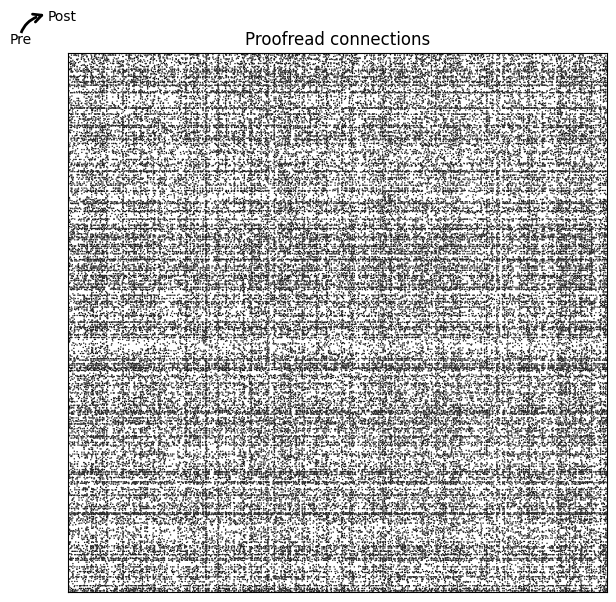

In [17]:
from matrix_plotting import adjacencyplot

fig, ax = plt.subplots(figsize=(7, 7))
ax, grid = adjacencyplot(
    syn_mat,
    ax=ax,
    title="Proofread connections",
)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3:</b> The matrix above only contains connections between <b>axon-proofread neurons</b>. Because many more dendrites of cells in the V1DD dataset are well-reconstructed <b>we can consider more connections than just the ones between proofread neurons.</b> Therefore, the connectivity matrix of analyzable connections forms a rectangular matrix. 
    
What is the size of the matrix between the proofread neurons and all neurons with a cell body in the dataset?
    
</div>

In [18]:
# Select synapses from proofread cells onto all cells 
proof_all_syn_table = filter_synapse_table(
    syn_df, pre_root_ids=axon_proof_root_ids, post_root_ids=dendrite_proof_root_ids
)

print(len(proof_all_syn_table))

rect_syn_mat = make_adjacency(
    syn_df,
    source_cell_index=axon_proof_root_ids,
    target_cell_index=dendrite_proof_root_ids,
)
rect_syn_mat.shape

1489628


(1207, 63937)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h4> Consider: different measures of synaptic strength </h4>

When creating a connectivity matrix, how you measure synaptic strength can make a difference in your analysis. For EM data there are 3 common ways of reporting connection strength:

<ol>
    <li> <b> Binary connectivity:</b> whether two cells are connected at all, as shown above.</li>
    <li> <b> Synaptic count:</b> the total number of synapses as part of the connection. This is typical of the Fly connectome where <code>count</code> captures much of the connection diversity. The modal <code>count</code> in mouse cortex is much lower.</li>
    <li> <b> Synaptic size:</b> the size of the postsynaptic density at every connection, generally aggregated as <code>mean</code> or <code>sum</code> for each unique connection.</li>
    
</ol>
How to take synapse size and number into account depends on the specific analysis. 

The `size` reported in the V1DD dataset measures the synaptic cleft as segmented by the automated classifier in voxels (3d pixels, a measure of volume). These are correlated to anatomical measures such as synaptic area and spine head volumes (for excitatory synapses). 

Let's replot the <b>square matrix</b> with the <code>mean</code> of synapses sizes between each connected pair.

</d>

In [19]:
# get the ids of all proofread cells (same as for the binary connectivity)
proof_root_ids = axon_proof_root_ids[
    np.isin(axon_proof_root_ids, dendrite_proof_root_ids)
]

# Now with the aggregation function set to 'mean' synapse size
syn_mat = make_adjacency(syn_df, source_cell_index=proof_root_ids, aggfunc="mean")
syn_mat.data

array([2620.,  898., 1276., ...,  846.,  309., 1845.], shape=(90295,))

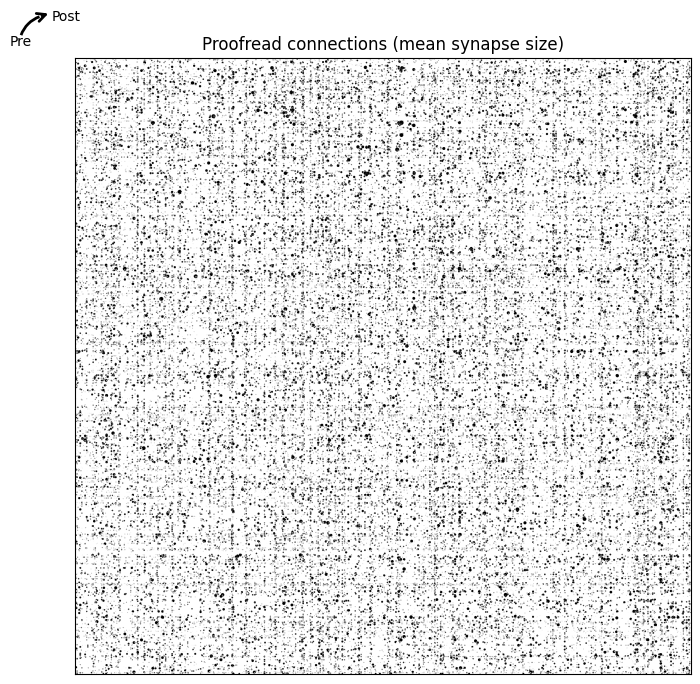

In [20]:
ax, grid = adjacencyplot(
    syn_mat,
    edge_hue=True,
    edge_size=True,
    edge_palette="Greys",
    sizes=(0.1, 10),  # set the min and max size of the dots
    hue_norm=(0.3, 1),  # set how to scale colors
    title="Proofread connections (mean synapse size)",
)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Depending on the connection type, number of synapses might be the more important measure (see [Dorkenwald et al., 2022](https://elifesciences.org/articles/76120) for deeper dive into synapse size and counts). 

Next we plot the <b>number of synapses per connection</b> or the <code>count</code>(we limit the colorbar to a maximum of 5 but the actual max number is much higher):


</d>

In [21]:
syn_mat = make_adjacency(syn_df, proof_root_ids, aggfunc=lambda x: np.sum(x > 0))
# show the first 10 nonzero values in the sparse array
syn_mat.data[:10]


array([1, 1, 3, 1, 1, 1, 1, 1, 1, 1])

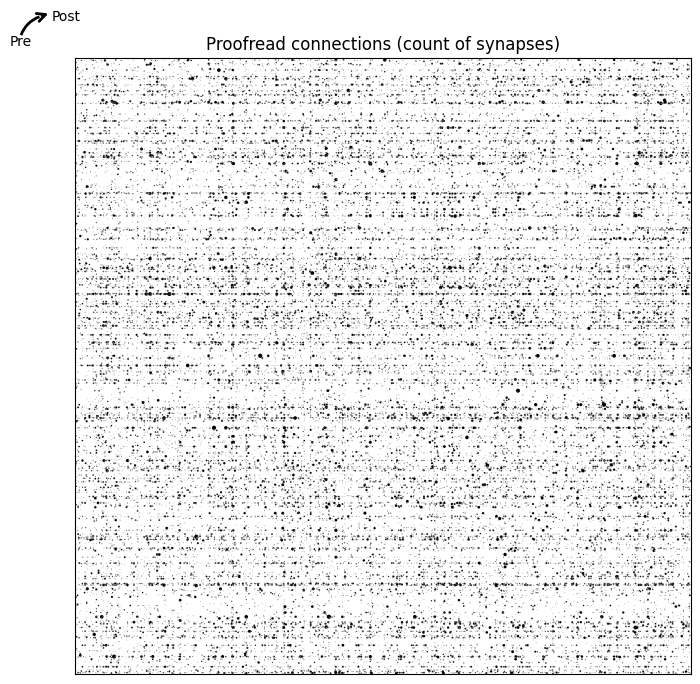

In [22]:
ax, grid = adjacencyplot(
    syn_mat,
    edge_hue=True,
    edge_size=True,
    edge_palette="Greys",
    sizes=(0.1, 10),  # set the min and max size of the dots
    hue_norm=(0.3, 1),  # set how to scale colors
    title="Proofread connections (count of synapses)",
)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

You will have the opportunity to explore different measures of synaptic strength and how it informs your results as part of <b>Exercise 1</b>. 

</d>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Cell type tables

Identifying the putative ‘cell type’ from the EM morphology is a process that involves both manual and automatic classifications. Subsets of the dataset have been manually classified by anatomists at the Allen Institute, and these ground truth labels used to train and refine different automated ‘feature classifiers’ over time. 

Two of the most predictive features for broad cell type are:

<ul>
    <li>Soma location (in units of depth from pial surface). This captures <b>cortical layer diversity</b></li>
    <li>Soma size (in units of volume). This is a strong proxy of many types of <b>cell morpholigical diversity</b></li>
</ul>

<font size=4>Load the cell types data and plot all the cells by these two features</font>
    
</d>

In [23]:
cell_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")

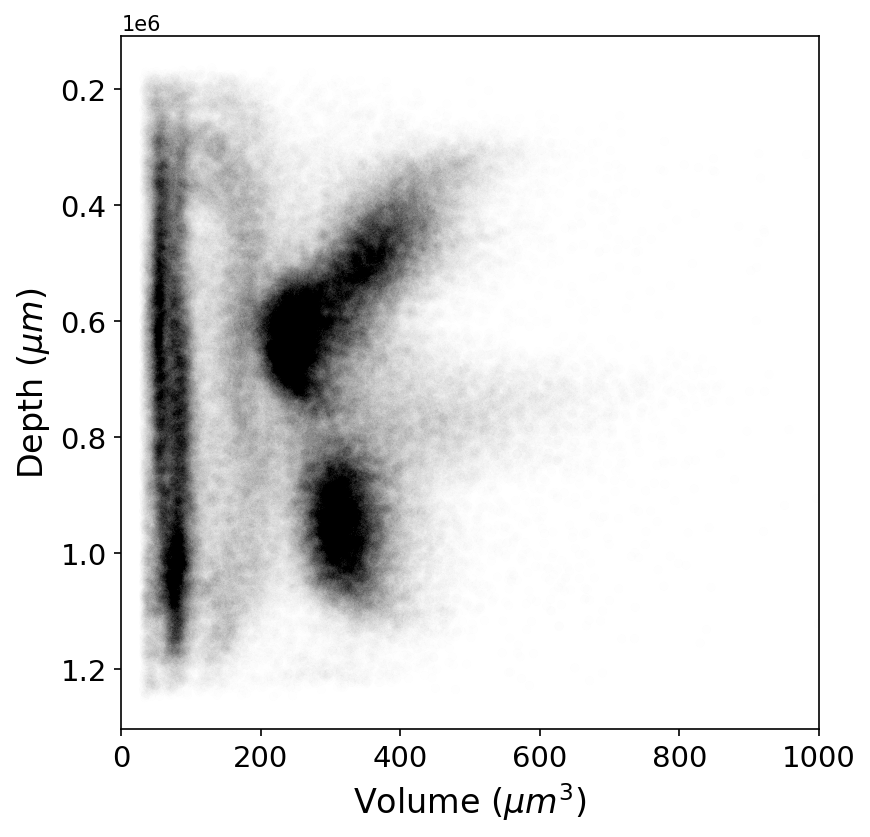

In [24]:
# Plot cell volume by depth
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.tick_params(labelsize=14)
sns.scatterplot(
    data=cell_df,
    x="volume",
    y="pt_position_y",
    size=1,
    edgecolor=None,
    alpha=0.005,
    color="k",
    ax=ax,
    legend=False,
)
ax.invert_yaxis()
ax.set_xlabel(r"Volume ($\mu m^3$)", fontsize=16)
ax.set_ylabel(r"Depth ($\mu m$)", fontsize=16)
ax.set_xlim(0, 1000)
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Using the automated cell types

Many of these automated cell type definitions were established and refined for the [MICrONS Dataset](https://www.microns-explorer.org/) including: 

<ul>
    <li> Perisomatic cell features (Elabbady et al.) </li>
    <li> Morphology and connectivity features (Schneider-Mizell et al.) </li>
</ul>

The process of applying these labels to the V1DD dataset is ongoing, but we will use cell typing from the <code>cell_type_multifeature_v1</code> table which labels cell types according to using soma, nucleus, dendrite, and spine features. 

Excitatory neurons are labeled by projection category (IT, ET, NP, CT, and SP for subplate). 

Inhibitory neurons follow labels based on targeting such as ITC (inhibitory targeting), STC (sparsely targeting), PTC (perisomatic targeting), and DTC (dendrite targeting), but might align more with molecular class than exact targeting for a given neuron, particularly among ITC/VIP cells.

*Note:* Cells here without a label will remain black. These are either non-neuronal cells or potential neurons with large segmentation errors that did not pass quality check
    
</d>

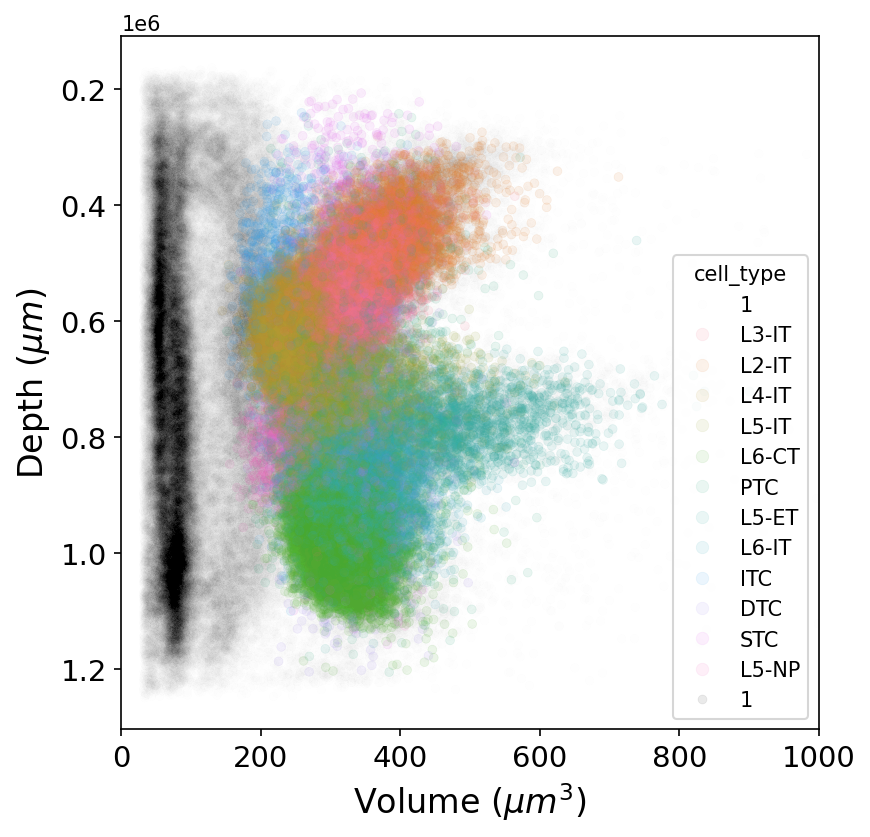

In [25]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.tick_params(labelsize=14)
sns.scatterplot(
    data=cell_df,
    x="volume",
    y="pt_position_y",
    size=1,
    edgecolor=None,
    alpha=0.005,
    color="k",
    ax=ax,
    legend=True,
)
sns.scatterplot(
    data=cell_df,
    x="volume",
    y="pt_position_y",
    size=1,
    edgecolor=None,
    alpha=0.1,
    color="k",
    ax=ax,
    legend=True,
    hue="cell_type",
)
ax.invert_yaxis()
ax.set_xlabel(r"Volume ($\mu m^3$)", fontsize=16)
ax.set_ylabel(r"Depth ($\mu m$)", fontsize=16)
ax.set_xlim(0, 1000)
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Sorting the synapse matrix with cell types
    
Let's combine the synaptic connecitivity with the cell type information. Below we provide logic for sorting a connectivity matrix using a list of labels.    
    
</d>

In [26]:
# Filter the proofread ids for those with a known cell type
proof_root_ids = np.intersect1d(proof_root_ids, cell_df["pt_root_id"].values)

# Filter the cell type table for those with a proofread root id
proof_cell_df = cell_df.set_index("pt_root_id").loc[proof_root_ids]
proof_cell_df = proof_cell_df.query("cell_type.notna()")

# Make adjacency, now including soma depth and cell type
syn_mat = make_adjacency(syn_df, proof_cell_df, aggfunc="sum")

(<Axes: title={'center': 'Proofread connectivity (sorted by depth)'}>,
 <matrix_plotting.AxisGrid at 0x23ed4253450>)

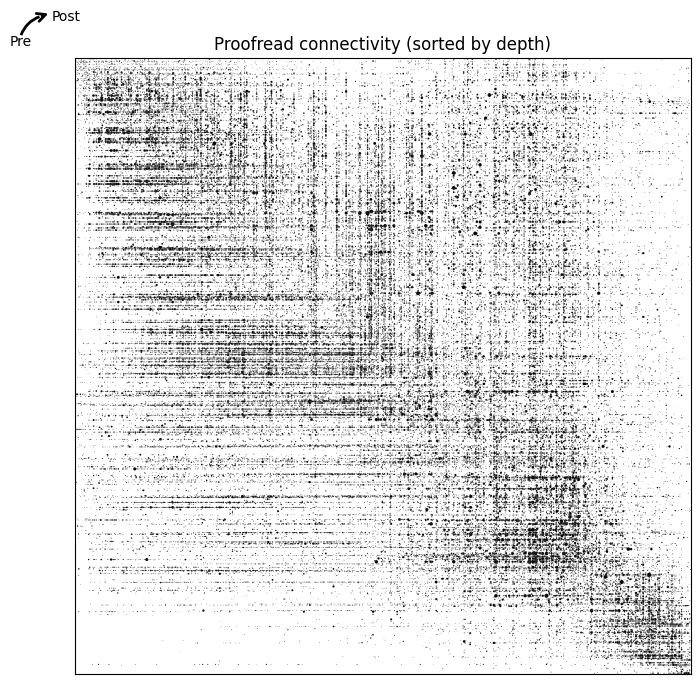

In [27]:
# Set the adjacency plot arguments 
adjplot_kws = dict(
    edge_hue=False,
    edge_size=True,
    edge_palette="Greys",
    sizes=(0.1, 10),  # set the min and max size of the dots
    hue_norm=(-1, 1),  # set how to scale colors
)

# render the adjacency plot
adjacencyplot(
    syn_mat, # data values for the points
    nodes=proof_cell_df, # data to organize the x and y axis
    sortby="pt_position_y", # sort within groups by variable
    title="Proofread connectivity (sorted by depth)",
    **adjplot_kws,
)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 4:</b> There is a large amount of structure in the connectivity, just based on soma depth! However, some rows are very narrow in their connectivty while others are very wide.
    
<p><b>Discussion:</b> What are some explanations for why the connectivity plot has a strong diagonal component? In contrast, what does the wide connectivity in a row/column mean </p>
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Add cell type logic to adjacency plot
    
Now we get the convenience of the adjacency plot! We can add colors and subplots by cell type to make this matrix more tractable.

The logic here is similar to the plotting package `seaborn`, where different labels within the data can be leveraged to control different elements.
    
</d>

In [28]:
# Create a color pallete based on cell type and class
node_hue = "cell_type"

n_e_classes = len(proof_cell_df.query("cell_type_coarse == 'E'")[node_hue].unique())
n_i_classes = len(proof_cell_df.query("cell_type_coarse == 'I'")[node_hue].unique())

e_colors = sns.cubehelix_palette(
    start=0.4, rot=0.3, light=0.85, hue=1.0, dark=0.4, gamma=1.3, n_colors=n_e_classes
)

i_colors = sns.cubehelix_palette(
    start=0.3, rot=-0.4, light=0.75, dark=0.2, hue=1.0, gamma=1.3, n_colors=n_i_classes
)

cell_type_palette = dict(
    zip(
        proof_cell_df.sort_values(["cell_type_coarse", node_hue])[node_hue].unique(),
        e_colors + i_colors,
    )
)

cell_type_palette["E"] = np.array(list(e_colors)).mean(axis=0)
cell_type_palette["I"] = np.array(list(i_colors)).mean(axis=0)

(<Axes: >, <matrix_plotting.AxisGrid at 0x23ecee82390>)

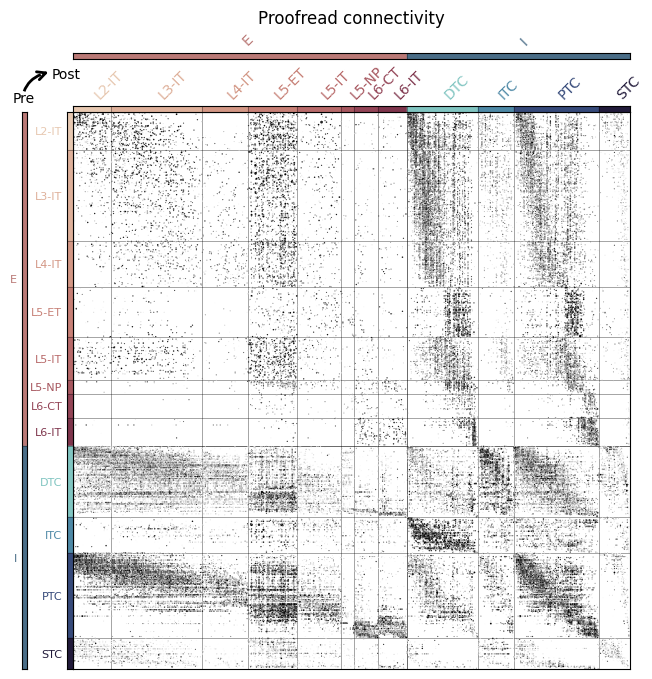

In [29]:
# Set the adjacency plot arguments 
adjplot_kws = dict(
    edge_hue=True,
    edge_size=True,
    edge_palette="Greys",
    sizes=(0.5, 5),  # set the min and max size of the dots
    hue_norm=(0, 1),  # set how to scale colors
)

# render the adjacency plot
adjacencyplot(
    syn_mat, # data values for the points
    nodes=proof_cell_df, # data to organize the x and y axis
    groupby=["cell_type_coarse", "cell_type"], # categorical variables to organize by
    sortby="pt_position_y", # sort within groups by variable
    node_palette=cell_type_palette,
    title="Proofread connectivity",
    **adjplot_kws,
)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 5:</b> Now we have restructured the connectivity based on cell type. Find one of your example cells from earlier and identify it's row or column. Hint: query the <code>proof_cell_df</code> by your <code>root_id</code>

<b>Discussion:</b> Describe the connectivity for your cell by who it targets and who it recieves inputs from.

Then, for each row describe that cell type by it's major targets. Do you think there are more subgroups within the cell types?
    
</div>

In [30]:
proof_cell_df.query(f"pt_root_id=={root_id}")[['cell_type_coarse','cell_type']]

,cell_type_coarse,cell_type
pt_root_id,,
864691132534315610,E,L4-IT
